# 2 (30 puntos) Perceptrón multi-capa para detección de glaucoma en imágenes de fondo de ojo

1. Modifique el perceptrón multi-capa y la red convolucional implementadas en el codigo base provisto. Explique las modificaciones necesarias para implementar que ambos modelos funcionen para el objetivo especificado.

## Imports

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch import nn, optim
from matplotlib import cm
from matplotlib import style
from locale import normalize
from matplotlib.pyplot import imshow

%matplotlib widget
style.use('default')

## Parámetros

In [3]:
lr = 0.01 # Learning rate empleado para la función de optimización SGD
epochs = 15 # Cantidad de iteraciones que se ejecutaran por cada intento
attempts = 10 # Cantidad de intentos totales que se ejecutaran (en cada uno de los cuales se creará el modelo, entrenará y obtendrán datos de efectividad)
img_size = 227 # Tamaño asignado para el width y height de las imágenes para entrenar y probar.
batch_size = 32 # Cantidad de imágenes que serán procesadas por lote.
criterion = nn.NLLLoss() # Función de perdida que se calculará individualmente para cada iteración y que se suma al total del intento
ruta_base = r'.\\DatosDePrueba\\' # Ruta de la computadora a partir de la cual se accede a los datos de prueba
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Dispositivo en el que se ejecutará
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_size, img_size))]) # Transformaciones aplicadas a los sets de entrenamiento y pruebas (todas las imágenes se ajustan al cuadrado img_size)

## Cargado de datos de entrenamiento y prueba

[Batch_size, channels, img_size, img_size] =, torch.Size([32, 3, 227, 227])


C:\Users\XPC\AppData\Local\Temp\ipykernel_40908\2524731925.py:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2985.)
  axs[0,0].imshow(images[0].T.numpy().squeeze(), cmap='gray_r')


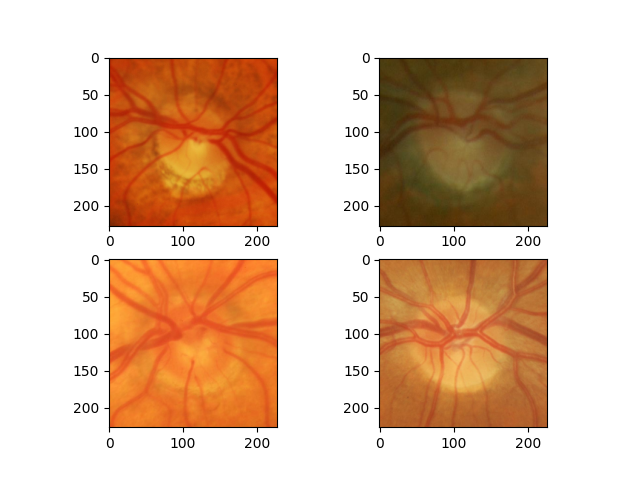

In [4]:
def load_data(nom_carpeta): # Carga imágenes desde el folder según el nombre que se indique
    set = torchvision.datasets.ImageFolder(ruta_base + nom_carpeta, transform = transform)
    loader = torch.utils.data.DataLoader(set, batch_size = batch_size, shuffle = True)
    return loader

def load_test_train_data(): # Carga imágenes de entrenamiento y pruebas
    trainloader = load_data('train')
    testloader = load_data('test')
    return trainloader, testloader
    
trainloader, testloader = load_test_train_data()
dataiter = iter(trainloader)
images, labels = dataiter.next()


print('[Batch_size, channels, img_size, img_size] =,', images.mT.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(images[0].T.numpy().squeeze(), cmap='gray_r')
axs[0,1].imshow(images[1].T.numpy().squeeze(), cmap='gray_r')
axs[1,0].imshow(images[2].T.numpy().squeeze(), cmap='gray_r')
axs[1,1].imshow(images[3].T.numpy().squeeze(), cmap='gray_r')

## Creando el modelo del perceptrón multicapa

In [5]:
def create_MLP_model(verbose = True): # Creación del modelo
  model = nn.Sequential(
    nn.Linear(img_size*img_size*3,128), # Empleando como entrada las dimensiones de la imagen (w * h) multiplicado por los 3 canales de color que se están utilizando => 154587 = 227 * 227 * 3
    nn.ReLU(),
    nn.Linear(128,64),
    nn.Sigmoid(),
    nn.ReLU(),
    nn.Linear(64,2),
    nn.LogSoftmax(dim=1))
  
  if (verbose): print("Running on device: ", device)
  model.to(device)
  return model

mlp_model = create_MLP_model()
print("MLP model")
print(mlp_model)

Running on device:  cuda
MLP model
Sequential(
  (0): Linear(in_features=154587, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Sigmoid()
  (4): ReLU()
  (5): Linear(in_features=64, out_features=2, bias=True)
  (6): LogSoftmax(dim=1)
)


## Entrenando el modelo

In [6]:
def train_model(model, criterion, epochs, lr, verbose = True):
    start = time()
    epochs_list = []
    running_loss_list= []
    optimizer = optim.SGD(model.parameters(), lr= lr, momentum=0.9)

    for e in range(epochs):
        running_loss = 0
        
        for images, labels in trainloader: # Ejecución de la iteración por lotes
            images = images.to(device) # Se preparan las imágenes del lote en el device usado
            labels = labels.to(device)            
            images = images.view(images.shape[0], -1) 
            
            optimizer.zero_grad()
            output = model(images) # Aplicando el modelo para cada batch
            loss = criterion(output, labels) # Y calculando el error asociado
            loss.backward() # Aprendizaje por backpropagation
            optimizer.step() # weights optimization
            running_loss += loss.item() # Se suma la pérdida para el total de la iteración

        else:
            if (verbose): print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

    if (verbose): print("\nTraining Time (in minutes) =",(time()-start)/60)
    return model

print("Training MLP model")
print("Device", next(mlp_model.parameters()).is_cuda)

mlp_model = train_model(mlp_model, criterion, epochs, lr)

Training MLP model
Device True
Epoch 0 - Training loss: 0.6504810824990273
Epoch 1 - Training loss: 0.49815657921135426
Epoch 2 - Training loss: 0.40077480021864176
Epoch 3 - Training loss: 0.36659320816397667
Epoch 4 - Training loss: 0.2982443906366825
Epoch 5 - Training loss: 0.3191382675431669
Epoch 6 - Training loss: 0.3426050590351224
Epoch 7 - Training loss: 0.3290779097005725
Epoch 8 - Training loss: 0.33930585253983736
Epoch 9 - Training loss: 0.29024694999679923
Epoch 10 - Training loss: 0.2952217971906066
Epoch 11 - Training loss: 0.27579277008771896
Epoch 12 - Training loss: 0.22897756332531571
Epoch 13 - Training loss: 0.30063611129298806
Epoch 14 - Training loss: 0.32749072927981615

Training Time (in minutes) = 0.649629024664561


## Probando el modelo

In [9]:
def test_model_mlp(testloader, model, verbose = True):
    correct_rate, false_positive_rate, false_negative_rate, all_count = 0, 0, 0, 0
    
    for images,labels in testloader:
      images = images.to(device)  # Se preparan las imágenes del lote en el device usado
      labels = labels.to(device)

      for i in range(len(labels)): # se itera sobre los índices de targets
        img = images[i].view(1, img_size*img_size*3)
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab)) # Se obtiene el target predicho de la iteración actual
        true_label = labels.cpu().numpy()[i] # Se obtiene el target correcto de la iteración actual
        
        if (true_label == pred_label): correct_rate += 1 # Predicción correcta si igual a target
        else:
          if (pred_label == '0'): false_negative_rate += 1 # Falso negativo si predicción es 0 pero correcto 1
          else: false_positive_rate += 1 # Falso positivo si predicción es 1 pero correcto 0

        all_count += 1

    if (verbose):
      print("Images Tested =", all_count)
      print("Correct Tests =", correct_rate)
      print("False Positive Tests =", false_positive_rate)
      print("False Negative Tests =", false_negative_rate)
      print("\nModel Accuracy =", (correct_rate/all_count))

    return correct_rate, false_positive_rate, false_negative_rate, all_count

print("Testing MLP model")
res = test_model_mlp(testloader, mlp_model)

Testing MLP model
Images Tested = 210
Correct Tests = 161
False Positive Tests = 49
False Negative Tests = 0

Model Accuracy = 0.7666666666666667


## Ejecuciones consecutivas de entrenamiento y pruebas

a) Entrene el perceptrón multi-capa usando el conjunto de datos completo para entrenamiento y validación. Calibre los hiper-parámetros necesarios para obtener los mejores resultados posibles y reportelos. Ejecute el entrenamiento 10 veces por 15 épocas por corrida, y reporte la tasa de aciertos tasa de aciertos, falsos positivos y falsos negativos promedio y su desviación estándar para esas 10 corridas.

In [10]:
print('{} training and testing attempts:\n'.format(attempts))
aciertos = []

for i in range(attempts):
    mlp_model = create_MLP_model(False)
    mlp_model = train_model(mlp_model, criterion, epochs, lr, False)
    correct_rate, false_positive_rate, false_negative_rate, all_count = test_model_mlp(testloader, mlp_model, False)
    aciertos.append(correct_rate)

    print('Results of attempt #{}:'.format(i))
    print('\tCorrect: {}\tFalse Positive Tests: {}\tFalse Negative Tests: {}\tModel Accuracy: {}\n'.format(correct_rate, false_positive_rate, false_negative_rate, correct_rate/all_count))

resultados = torch.tensor(aciertos)
print('Average correct tests:{}\n'.format(torch.mean(resultados.double()).item()))
print('Standard deviation:{}\n'.format(torch.std(resultados.double()).item()))

10 training and testing attempts:

Results of attempt #0:
	Correct: 189	False Positive Tests: 21	False Negative Tests: 0	Model Accuracy: 0.9

Results of attempt #1:
	Correct: 159	False Positive Tests: 51	False Negative Tests: 0	Model Accuracy: 0.7571428571428571

Results of attempt #2:
	Correct: 175	False Positive Tests: 35	False Negative Tests: 0	Model Accuracy: 0.8333333333333334

Results of attempt #3:
	Correct: 174	False Positive Tests: 36	False Negative Tests: 0	Model Accuracy: 0.8285714285714286

Results of attempt #4:
	Correct: 178	False Positive Tests: 32	False Negative Tests: 0	Model Accuracy: 0.8476190476190476

Results of attempt #5:
	Correct: 134	False Positive Tests: 76	False Negative Tests: 0	Model Accuracy: 0.638095238095238

Results of attempt #6:
	Correct: 191	False Positive Tests: 19	False Negative Tests: 0	Model Accuracy: 0.9095238095238095

Results of attempt #7:
	Correct: 192	False Positive Tests: 18	False Negative Tests: 0	Model Accuracy: 0.9142857142857143

Resul

Image [channel, img_size, img_size] = torch.Size([3, 227, 227])


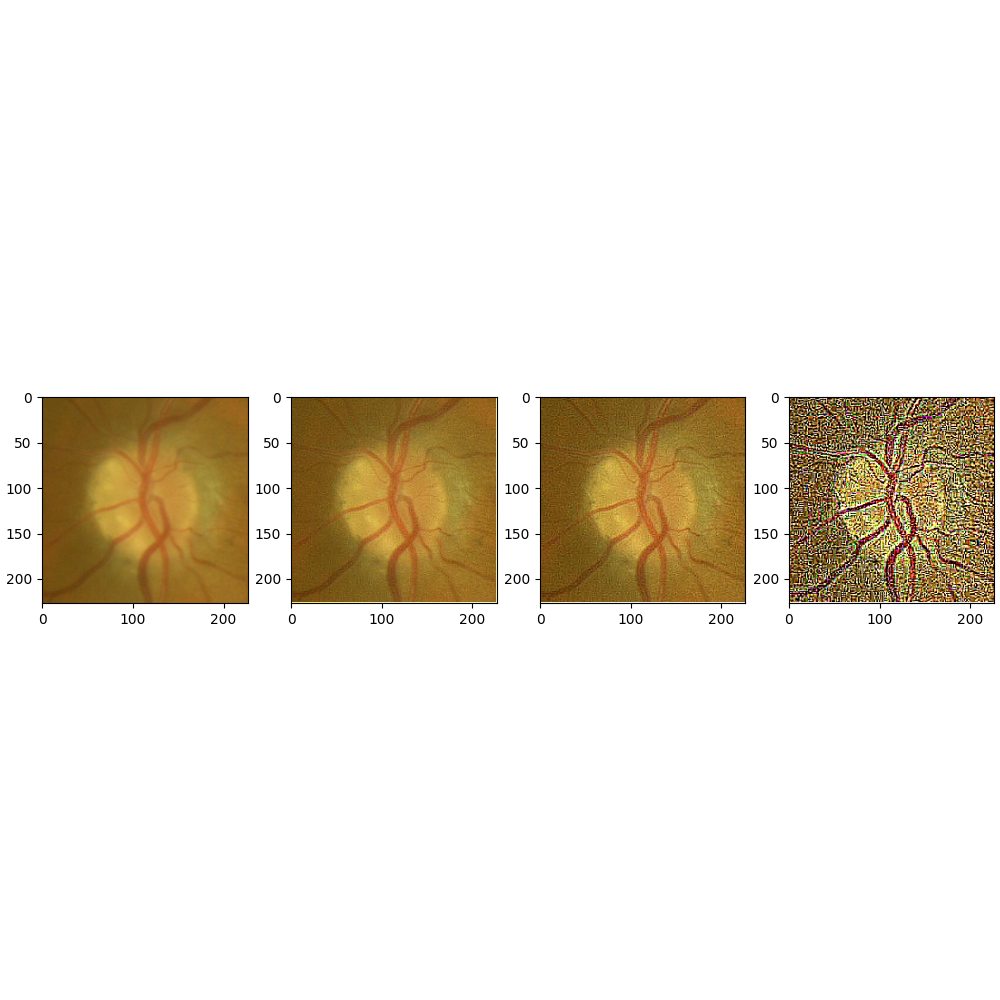

In [14]:
#Punto 3.1 del TP01
#Gaussian blur filter
def gaussian_blur():
    #Gaussian blur filter
    F = torch.tensor([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]]).float()
    return F

### Convlution for unsharp masking
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels

#Manual convlution method for 3 channel images.
def convolution(U,F):

    new_size = calculate_target_size(img_size=U.shape[1],kernel_size=U.shape[0])

    kernel=F

    kernel_shape = kernel.shape[0]

    conv_img = torch.zeros(3,new_size,new_size)
    
    for g in range(3):
        for i in range(new_size):
            for j in range(new_size):
                mat = U[g,i:i+kernel_shape,j:j+kernel_shape]
                conv_img[g, i, j] = torch.sum(torch.multiply(mat,kernel))

    #Add padding to the convuluted image so the size is the same for original and convoluted image.
    conv_img=torchvision.transforms.Pad(1)(conv_img)
    
    return conv_img

def unsharp_masking(U,amount):
    return U + (U-convolution(U,gaussian_blur())) * amount

U = read_image(ruta_base + '\\train\\0\\Im106_ACRIMA.jpg') / 255
U=torchvision.transforms.Resize(img_size)(U)
print('Image [channel, img_size, img_size] =', U.shape)

def disp(x): return (x.clamp(0,1) * 255).byte().permute(1,2,0).cpu()

fig, (ax, bx, cx, dx) = plt.subplots(1,4, figsize=(10,10),label="Convolution test")
ax.imshow(disp(U))
bx.imshow(disp(unsharp_masking(U,5)))
cx.imshow(disp(unsharp_masking(U,10)))
dx.imshow(disp(unsharp_masking(U,150)))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


In [16]:
def create_AlexNet_model():
    class AlexNet(nn.Module):
        def __init__(self):
            super(AlexNet, self).__init__()

            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer5 = nn.Sequential(
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(9216, 4096),
                nn.ReLU())
            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, 2),nn.LogSoftmax(dim=1))

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out
 
    cnn = AlexNet()
    return cnn

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on device: ", device)
mlp_model = create_MLP_model()

#moving models to device
mlp_model.to(device)
cnn_model = create_AlexNet_model()
cnn_model.to(device)
#error function
criterion = nn.NLLLoss() 
print("MLP model")
print(mlp_model)
print("CNN model ")
print(cnn_model)

Running on device:  cuda
Running on device:  cuda
MLP model
Sequential(
  (0): Linear(in_features=154587, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Sigmoid()
  (4): ReLU()
  (5): Linear(in_features=64, out_features=2, bias=True)
  (6): LogSoftmax(dim=1)
)
CNN model 
AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), p

In [17]:
def train_model(model, criterion, epochs, lr, is_MLP = False):

    time0 = time()    
    running_loss_list= []
    epochs_list = []
    optimizer = optim.SGD(model.parameters(), lr= lr, momentum=0.9)
    for e in range(epochs):
        running_loss = 0
        
        #go for every batch
        for images, labels in trainloader:
            #move data to specific device
            images = images.to(device)
            labels = labels.to(device)
            # Flatenning MNIST images with size [64,784] (for MLP)
            if(is_MLP):
              images = images.view(images.shape[0], -1) 
            
            # defining gradient in each epoch as 0
            optimizer.zero_grad()            
            # modeling for each image batch
            output = model(images)

            # calculating the loss
            loss = criterion(output, labels)

            # This is where the model learns by backpropagating
            loss.backward()

            # And optimizes its weights here
            optimizer.step()

            # calculating the loss
            running_loss += loss.item()

        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    return model


print("Training CNN model")
cnn_model = train_model(cnn_model, criterion, epochs, lr, is_MLP = False)

print("Training MLP model")
mlp_model = train_model(mlp_model, criterion, epochs, lr, is_MLP = True)

Training CNN model
Epoch 0 - Training loss: 0.4912370895035565
Epoch 1 - Training loss: 0.5413114172406495
Epoch 2 - Training loss: 0.3200004184618592
Epoch 3 - Training loss: 0.25253104232251644
Epoch 4 - Training loss: 0.2674454231746495
Epoch 5 - Training loss: 0.17246316000819206
Epoch 6 - Training loss: 0.181042336858809
Epoch 7 - Training loss: 0.14700702083064243
Epoch 8 - Training loss: 0.17602919519413263
Epoch 9 - Training loss: 0.20299856131896377
Epoch 10 - Training loss: 0.13764833193272352
Epoch 11 - Training loss: 0.11405066587030888
Epoch 12 - Training loss: 0.17072883364744484
Epoch 13 - Training loss: 0.10911635612137616
Epoch 14 - Training loss: 0.0773530481965281

Training Time (in minutes) = 0.750521719455719
Training MLP model
Epoch 0 - Training loss: 0.6842518448829651
Epoch 1 - Training loss: 0.6223030462861061
Epoch 2 - Training loss: 0.47034503892064095
Epoch 3 - Training loss: 0.45970007963478565
Epoch 4 - Training loss: 0.3635320793837309
Epoch 5 - Training 

In [18]:
def test_model_mlp(testloader, model):
    correct_count, all_count = 0, 0
    for images,labels in testloader:
      #move data to specific device
      images = images.to(device)
      labels = labels.to(device)
      for i in range(len(labels)):
        img = images[i].view(1, 227*227*3)
        #evaluate model with no grad
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        #get predicted label
        pred_label = probab.index(max(probab))
        true_label = labels.cpu().numpy()[i]
        if(true_label == pred_label):
          correct_count += 1
        all_count += 1

    print("Number Of Images Tested =", all_count)
    print("Number Of Correct Tests =", correct_count)
    print("\nModel Accuracy =", (correct_count/all_count))

def test_model_cnn(testloader, model):
  correct_count, all_count = 0, 0
  for images,labels in testloader:
    #move data to specific device
    images = images.to(device)
    labels = labels.to(device)
    #get model output
    with torch.no_grad():
      outputs = model(images)
    for i in range(len(labels)):
      #apply exp as the activation function has the log
      output_observation = torch.exp(outputs[i, :])
      #get predicted label
      output_observation_np = list(output_observation.cpu().numpy())
      pred_label = output_observation_np.index(max(output_observation_np))
      #get the label
      true_label = labels.cpu().numpy()[i]
      if(true_label == pred_label):
        correct_count += 1
      all_count += 1   

  print("Number Of Images Tested =", all_count)
  print("Number Of Correct Tests =", correct_count)
  print("\nModel Accuracy =", (correct_count/all_count))

print("Tesing CNN model")
test_model_cnn(testloader, cnn_model)
print("Testing MLP model")
test_model_mlp(testloader, mlp_model)

Tesing CNN model
Number Of Images Tested = 210
Number Of Correct Tests = 198

Model Accuracy = 0.9428571428571428
Testing MLP model
Number Of Images Tested = 210
Number Of Correct Tests = 186

Model Accuracy = 0.8857142857142857
